In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import re
import random
import string
import matplotlib.pyplot as plt
from utilities import clean_arabic_tweet
from utilities import remove_repeating_char, remove_punctuations, remove_diacritics, normalize_arabic, remove_single_char_word
from utilities import remove_common_words, remove_duplicate_words, remove_rare_words
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tqdm import tqdm
from collections import OrderedDict


In [3]:
pd.set_option('display.max_colwidth', -1)

# Data Preprocessing

## Loading Train Data

In [4]:
train_data_path = './data/DA_train_labeled.tsv'
test_data_path = './data/DA_dev_labeled.tsv'

In [5]:
train_data = pd.read_csv(train_data_path, sep='\t')
test_data = pd.read_csv(test_data_path, sep='\t')

## Delete province_labels 

In [6]:
del train_data['#4_province_label']
del test_data['#4_province_label']

## Plot tweets ferquency for every country

<AxesSubplot:>

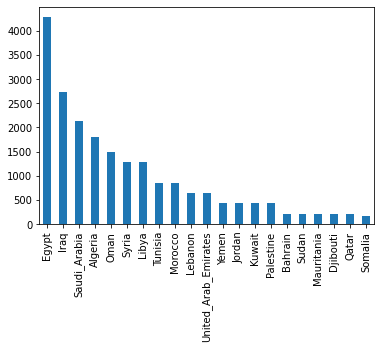

In [7]:
fig, ax = plt.subplots()
train_data['#3_country_label'].value_counts().plot(ax=ax, kind='bar')

<AxesSubplot:>

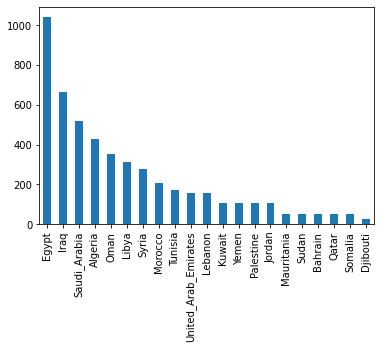

In [8]:
fig, ax = plt.subplots()
test_data['#3_country_label'].value_counts().plot(ax=ax, kind='bar')

In [9]:
test_data['#3_country_label'].value_counts()

Egypt                   1041
Iraq                    664 
Saudi_Arabia            520 
Algeria                 430 
Oman                    355 
Libya                   314 
Syria                   278 
Morocco                 207 
Tunisia                 173 
United_Arab_Emirates    157 
Lebanon                 157 
Kuwait                  105 
Yemen                   105 
Palestine               104 
Jordan                  104 
Mauritania              53  
Sudan                   53  
Bahrain                 52  
Qatar                   52  
Somalia                 49  
Djibouti                27  
Name: #3_country_label, dtype: int64

In [10]:
train_data['#3_country_label'].value_counts()

Egypt                   4283
Iraq                    2729
Saudi_Arabia            2140
Algeria                 1809
Oman                    1501
Syria                   1287
Libya                   1286
Tunisia                 859 
Morocco                 858 
Lebanon                 644 
United_Arab_Emirates    642 
Yemen                   429 
Jordan                  429 
Kuwait                  429 
Palestine               428 
Bahrain                 215 
Sudan                   215 
Mauritania              215 
Djibouti                215 
Qatar                   215 
Somalia                 172 
Name: #3_country_label, dtype: int64

## preview samples 

In [11]:
# train_data.loc[train_data['#3_country_label'] == 'Somalia']

## clean tweets

### V1 cleaning

In [12]:
tarin_tweets_cleaned = (train_data['#2_tweet'].apply(clean_arabic_tweet))
test_tweets_cleaned = (test_data['#2_tweet'].apply(clean_arabic_tweet))

In [13]:
train_data['#2_tweet_clean_V1']= tarin_tweets_cleaned
test_data['#2_tweet_clean_V1']= test_tweets_cleaned

### v2 cleaning

#### loading stopwords

In [14]:
#remove arabic formal clitics from tweets.
stop_words_file = open('formal clitics stop words.txt','r',encoding="utf8")
stop_words_list = [line.strip() for line in stop_words_file]

#### normalize the stop words

In [15]:
stop_words_list_preprocessed = []
for word in stop_words_list:
    word_processed = remove_diacritics(word)
    word_processed = normalize_arabic(word_processed)
    word_processed = remove_repeating_char(word_processed)
    word_processed = remove_diacritics(word_processed)
    word_processed = remove_diacritics(word_processed)
#     print(word, word_processed)
    if len(word_processed)>1:
        stop_words_list_preprocessed.append(word_processed)

In [16]:
removed_words = []

In [17]:
def remove_stopwords(text):
    text_tokens = text.strip().split(" ")
    for word in text_tokens:
        if word in stop_words_list_preprocessed:
            removed_words.append(word)            
    #------------------------------------------------------------------------------------------------
    tokens_filtered= [word for word in text_tokens if not word in stop_words_list_preprocessed]
    return (" ").join(tokens_filtered)




In [18]:
train_data['#2_tweet_clean_V2']= train_data['#2_tweet_clean_V1'].apply(remove_stopwords)
    
test_data['#2_tweet_clean_V2']= test_data['#2_tweet_clean_V1'].apply(remove_stopwords)

In [19]:
len(removed_words)

47992

In [20]:
with open("./removed_stopwords_from_tweet.txt", 'w') as f:
    for word in removed_words:
        f.write(word+'\n')

### v3 cleaning

In [21]:
train_data['#2_tweet_clean_V3'] = remove_duplicate_words(train_data['#2_tweet_clean_V2'])
test_data['#2_tweet_clean_V3']= remove_duplicate_words(test_data['#2_tweet_clean_V2'])


train_data['#2_tweet_clean_V3']= remove_rare_words(train_data['#2_tweet_clean_V3'], 1)
test_data['#2_tweet_clean_V3']= remove_rare_words(test_data['#2_tweet_clean_V3'], 1)


train_data['#2_tweet_clean_V3'] = remove_common_words(train_data['#2_tweet_clean_V3'], 0.90)
test_data['#2_tweet_clean_V3']= remove_common_words(test_data['#2_tweet_clean_V3'], 0.90)


words removed:  0
words removed:  0
words_count 140995
minimum_words 126895.5
words_count 33415
minimum_words 30073.5


#### delete empty tweets

In [25]:
def remove_empty_tweets(df, column_name):
    nan_value = float("NaN")
    df.replace("", nan_value, inplace=True)
    df.dropna(subset = [column_name], inplace=True)
    return df


In [28]:
remove_empty_tweets(train_data, "#2_tweet_clean_V1")
remove_empty_tweets(train_data, "#2_tweet_clean_V2")
remove_empty_tweets(train_data, "#2_tweet_clean_V3")

remove_empty_tweets(test_data, "#2_tweet_clean_V1")
remove_empty_tweets(test_data, "#2_tweet_clean_V2")
remove_empty_tweets(test_data, "#2_tweet_clean_V3")

,#1_tweetid,#2_tweet,#3_country_label,#2_tweet_clean_V1,#2_tweet_clean_V2,#2_tweet_clean_V3
0,DEV_0,قولنا اون لاين لا يا علي اون لاين لا,Egypt,قولنا اون لاين لا يا علي اون لاين لا,قولنا اون لاين يا اون لاين,قولنا اون لاين يا
1,DEV_1,ههههه بايخه ههههه URL …,Oman,بايخه,بايخه,بايخه
2,DEV_2,ربنا يخليك يا دوك ولك المثل :D,Lebanon,ربنا يخليك يا دوك ولك المثل,ربنا يخليك يا دوك ولك المثل,ربنا يخليك يا دوك ولك المثل
3,DEV_3,#اوامر_ملكيه ياشباب اي واحد فيكم عنده شي يذكره بالعساف يجيبه له احرقه,Syria,اوامر ملكيه ياشباب اي واحد فيكم عنده شي يذكره بالعساف يجيبه له احرقه,اوامر ملكيه ياشباب فيكم عنده شي يذكره بالعساف يجيبه احرقه,اوامر ملكيه ياشباب فيكم عنده شي يذكره بالعساف يجيبه احرقه
4,DEV_4,شد عالخط حتى هيا اكويسه,Libya,شد عالخط حتى هيا اكويسه,شد عالخط اكويسه,شد عالخط اكويسه
...,...,...,...,...,...,...
4995,DEV_4995,و في الشتاء مستحيل يقب,Libya,في الشتاء مستحيل يقب,الشتاء مستحيل يقب,الشتاء مستحيل يقب
4996,DEV_4996,اكيد حبيبتي وانتِ في كيفك وكيف طيبة قلبك,Libya,اكيد حبيبتي وانت في كيفك وكيف طيبه قلبك,اكيد حبيبتي وانت كيفك وكيف طيبه قلبك,اكيد حبيبتي وانت كيفك وكيف طيبه قلبك
4997,DEV_4997,يسعد صباح الناس رايقه,Jordan,يسعد صباح الناس رايقه,يسعد الناس رايقه,يسعد الناس رايقه
4998,DEV_4998,فرحتهم فيهاا ياتقبرنييي USER .twitter.com/hUSuYYoE1b,Morocco,فرحتهم فيها ياتقبرني,فرحتهم ياتقبرني,فرحتهم ياتقبرني


#### add class id coloumn

In [29]:
classes_names = train_data['#3_country_label'].unique().tolist()
classes_map={}
for i,class_name in enumerate(classes_names):
    classes_map[class_name]=i


def find_class_id_from_name(class_name):
    return classes_map[class_name]

In [30]:
train_data['classes_id']=train_data['#3_country_label'].apply(find_class_id_from_name)
test_data['classes_id']=test_data['#3_country_label'].apply(find_class_id_from_name)

In [31]:
train_data.head(10)

,#1_tweetid,#2_tweet,#3_country_label,#2_tweet_clean_V1,#2_tweet_clean_V2,#2_tweet_clean_V3,classes_id
0,TRAIN_0,حاجة حلوة اكيد,Egypt,حاجه حلوه اكيد,حاجه حلوه اكيد,حاجه حلوه اكيد,0
1,TRAIN_1,عم بشتغلوا للشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعدائهم,Iraq,عم بشتغلوا لشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعداهم,عم بشتغلوا لشعب الاميركي يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعداهم,عم بشتغلوا لشعب الاميركي يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعداهم,1
2,TRAIN_2,ابشر طال عمرك,Saudi_Arabia,ابشر طال عمرك,ابشر طال عمرك,ابشر طال عمرك,2
3,TRAIN_3,منطق 2017: أنا والغريب علي إبن عمي وأنا والغريب وإبن عمي علي أخويا. #قطع_العلاقات_مع_قطر #موريتانيا_مع_قطر,Mauritania,منطق انا والغريب علي ابن عمي وانا والغريب وابن عمي علي اخويا قطع العلاقات مع قطر موريتانيا مع قطر,منطق والغريب ابن عمي وانا والغريب وابن عمي اخويا قطع العلاقات قطر موريتانيا قطر,منطق والغريب ابن عمي وانا وابن اخويا قطع العلاقات قطر موريتانيا,3
4,TRAIN_4,شهرين وتروح والباقي غير صيف ملينا,Algeria,شهرين وتروح والباقي غير صيف ملينا,شهرين وتروح والباقي صيف ملينا,شهرين وتروح والباقي صيف ملينا,4
5,TRAIN_5,يابنتى والله ما حد متغاظ ولا مفروس منك ولا بيحسدك انتى عره اساسا.,Syria,يابنتى واله ما حد متغاظ ولا مفروس منك ولا بيحسدك انتى عره اساسا,يابنتى واله حد متغاظ مفروس منك بيحسدك انتى عره اساسا,يابنتى واله حد متغاظ مفروس منك بيحسدك انتى عره اساسا,5
6,TRAIN_6,نفس الوقت بأكد على صاحبتي ان اي هدف هتحطه وتخططله هيبوظ والأفضل التشاؤم واننا نتوقع الأسوء دايما والفشل عشان منعشمش نفسنا ع الفاضي,Egypt,نفس الوقت باكد على صاحبتي ان اي هدف هتحطه وتخطله هيبوظ والافضل التشام وانا نتوقع الاسوء دايما والفشل عشان منعشمش نفسنا الفاضي,باكد صاحبتي هدف هتحطه وتخطله هيبوظ والافضل التشام وانا نتوقع الاسوء دايما والفشل عشان منعشمش نفسنا الفاضي,باكد صاحبتي هدف هتحطه وتخطله هيبوظ والافضل التشام وانا نتوقع الاسوء دايما والفشل عشان منعشمش نفسنا الفاضي,0
7,TRAIN_7,م تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك URL …,Egypt,تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك,تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك,تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك,0
8,TRAIN_8,ما يله دخل !,Oman,ما يله دخل,يله دخل,يله دخل,6
9,TRAIN_9,هو حلو بس يتخربط ع طلاب المدراس ليك مايغيرونه عدنا,Iraq,هو حلو بس يتخربط طلاب المدراس ليك مايغيرونه عدنا,حلو يتخربط طلاب المدراس ليك مايغيرونه عدنا,حلو يتخربط طلاب المدراس ليك مايغيرونه عدنا,1


In [32]:
test_data.head(10)

,#1_tweetid,#2_tweet,#3_country_label,#2_tweet_clean_V1,#2_tweet_clean_V2,#2_tweet_clean_V3,classes_id
0,DEV_0,قولنا اون لاين لا يا علي اون لاين لا,Egypt,قولنا اون لاين لا يا علي اون لاين لا,قولنا اون لاين يا اون لاين,قولنا اون لاين يا,0
1,DEV_1,ههههه بايخه ههههه URL …,Oman,بايخه,بايخه,بايخه,6
2,DEV_2,ربنا يخليك يا دوك ولك المثل :D,Lebanon,ربنا يخليك يا دوك ولك المثل,ربنا يخليك يا دوك ولك المثل,ربنا يخليك يا دوك ولك المثل,8
3,DEV_3,#اوامر_ملكيه ياشباب اي واحد فيكم عنده شي يذكره بالعساف يجيبه له احرقه,Syria,اوامر ملكيه ياشباب اي واحد فيكم عنده شي يذكره بالعساف يجيبه له احرقه,اوامر ملكيه ياشباب فيكم عنده شي يذكره بالعساف يجيبه احرقه,اوامر ملكيه ياشباب فيكم عنده شي يذكره بالعساف يجيبه احرقه,5
4,DEV_4,شد عالخط حتى هيا اكويسه,Libya,شد عالخط حتى هيا اكويسه,شد عالخط اكويسه,شد عالخط اكويسه,13
5,DEV_5,انا صاحي ميت مالضحك ايه داااااا,Egypt,انا صاحي ميت مالضحك ايه دا,صاحي ميت مالضحك دا,صاحي ميت مالضحك دا,0
6,DEV_6,لا مين أنتِ؟ ههههههههههههههههههههههههههههههههههههههههههههههههههههههه .,Saudi_Arabia,لا مين انت,مين,مين,2
7,DEV_7,جاي عبالي رشوف,Palestine,جاي عبالي رشوف,جاي عبالي رشوف,جاي عبالي رشوف,17
8,DEV_8,"""\""ان شاء الله تببوا إلي وإبقى إلكن كل العمر \"" أمينن يارب URL """,Morocco,ان شاء اله تبوا الي وابقى الكن كل العمر امين يارب,شاء اله تبوا وابقى الكن العمر يارب,شاء اله تبوا وابقى الكن العمر يارب,9
9,DEV_9,الله يلعنك انت اصلا مريض انتزعت من قلبك الرحه URL …,Egypt,اله يلعنك انت اصلا مريض انتزعت من قلبك الرحه,اله يلعنك مريض انتزعت قلبك الرحه,اله يلعنك مريض انتزعت قلبك الرحه,0


## save the cleaned data

In [33]:
train_data.to_csv("./cleaned_data/cleaned_train_data_for_subtask1.csv", index=False, encoding="utf-8-sig")
test_data.to_csv("./cleaned_data/cleaned_test_data_for_subtask1.csv", index=False, encoding="utf-8-sig")

## get unique words - vocab

In [34]:
vocab = []
for tweet in tqdm(train_data['#2_tweet_clean_V3'].tolist()):
    for word in  text_to_word_sequence(tweet):
        if word not in vocab:
            vocab.append(word)


100%|██████████| 20974/20974 [00:33<00:00, 618.80it/s]


In [50]:
len(vocab)

48685

## find unique vocab of each country

In [53]:
class_unique_words = {}
for class_name in train_data['#3_country_label'].unique().tolist():
    class_unique_words[class_name] = []

In [54]:
looped = 0
for tweet, class_name in zip(train_data['#2_tweet_clean_V3'].tolist(), train_data['#3_country_label'].tolist()):
    looped+=1
    for word in text_to_word_sequence(tweet):
        if word not in class_unique_words[class_name]:
            exist_in_another_country = False
            for key in class_unique_words.keys():
                if key == class_name:
                    continue
                elif word in class_unique_words[key]:
                    exist_in_another_country = True
                    class_unique_words[key].remove(word)
                    break
            if exist_in_another_country==False:
                class_unique_words[class_name].append(word)

In [55]:
country_name_unique_vocab ={}
country_name, unique_vocab =[], []
for class_name in class_unique_words.keys():
    country_name_unique_vocab[class_name] = len(class_unique_words[class_name])
    country_name.append(class_name)
    unique_vocab.append(len(class_unique_words[class_name]))



In [56]:
country_name_unique_vocab

{'Egypt': 6668,
 'Iraq': 6043,
 'Saudi_Arabia': 4126,
 'Mauritania': 649,
 'Algeria': 4018,
 'Syria': 2795,
 'Oman': 2449,
 'Tunisia': 1830,
 'Lebanon': 1558,
 'Morocco': 2130,
 'Djibouti': 355,
 'United_Arab_Emirates': 978,
 'Kuwait': 758,
 'Libya': 2483,
 'Bahrain': 362,
 'Qatar': 367,
 'Yemen': 895,
 'Palestine': 710,
 'Jordan': 718,
 'Somalia': 271,
 'Sudan': 375}

In [57]:
country_name_unique_vocab_df = df_ = pd.DataFrame(index=range(0,21), columns=['country_name', 'unique_vocab_count'])


In [58]:
country_name_unique_vocab_df['country_name'] = country_name
country_name_unique_vocab_df['unique_vocab_count'] = unique_vocab


In [59]:
country_name_unique_vocab_df.head(21)

,country_name,unique_vocab_count
0,Egypt,6668
1,Iraq,6043
2,Saudi_Arabia,4126
3,Mauritania,649
4,Algeria,4018
5,Syria,2795
6,Oman,2449
7,Tunisia,1830
8,Lebanon,1558
9,Morocco,2130


In [63]:
country_name_unique_vocab_df=country_name_unique_vocab_df.sort_values(by=['unique_vocab_count'], ascending=False)

<AxesSubplot:xlabel='country_name'>

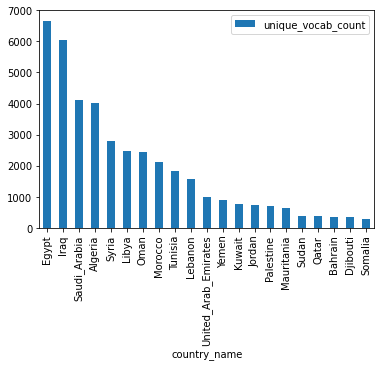

In [64]:
country_name_unique_vocab_df.plot(x='country_name', y='unique_vocab_count', kind='bar')